## Training Transformers

In this notebook we will provide an example of training transformers for text processing. As transformers are quite a heavy machinery, we will only use the encoder module of the transformer, and show how its output can be used for sentiment analysis, as we did with RNNs.

Once again, as we dealing with text processing, we will utilize *torchtext package*. Specifically, today we will carry out sentiment analysis based on movie reviews, taken from the IMDB review dataset.

In [1]:
!pip install torchtext==0.6.0 # the code uses an older version of torchtext
import torch
from torch import nn
import torch.nn.functional as f
import numpy as np
import torchtext.data as data
import torchtext.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data: IMDB Review Dataset

The IMDB review dataset is comprised of movie reviews gathered by the IMDB website. Each review is accompanied with a sentiment score, indicating whehter or not the reviewer like the movie.
This dataset is available via the *torchtext.datasets* package (the version recently converted to *legacy* in release 0.9.0), so the first thing we do is loading it.

In [2]:
max_len = 200
text = data.Field(sequential=True, fix_length=max_len, batch_first=True, lower=True, dtype=torch.long)
label = data.LabelField(sequential=False, dtype=torch.long)
datasets.IMDB.download('./')
ds_train, ds_test = datasets.IMDB.splits(text, label, path='./imdb/aclImdb/')

Each entry in the data set consists of a text sequence and a categorical sentiment, as shown below:

In [3]:
for i, line in enumerate(ds_train):
    if i > 20:
        break
    print(f'Movie review: {line.text[:5]}...; Sentiment score: {line.label}')

Movie review: ['this', 'is', 'a', 'very', 'fine']...; Sentiment score: pos
Movie review: ['i', 'thought', 'that', 'this', 'was']...; Sentiment score: pos
Movie review: ['i', 'have', 'read', 'over', '100']...; Sentiment score: pos
Movie review: ['robert', 'altman', 'is', 'my', 'favorite']...; Sentiment score: pos
Movie review: ['poor', 'ivy:', 'though', 'to', 'the']...; Sentiment score: pos
Movie review: ['i', 'really', 'enjoyed', 'this', 'debut']...; Sentiment score: pos
Movie review: ['chances', 'are', 'is', 'a', 'charming']...; Sentiment score: pos
Movie review: ['i', 'was', 'expecting', 'this', 'to']...; Sentiment score: pos
Movie review: ["you're", 'using', 'the', 'imdb.<br', '/><br']...; Sentiment score: pos
Movie review: ['the', 'color', 'purple', 'is', 'about']...; Sentiment score: pos
Movie review: ['famous', 'movies', 'are', 'subject', 'to']...; Sentiment score: pos
Movie review: ['follow', 'the', 'fleet,', 'an', 'rko']...; Sentiment score: pos
Movie review: ['i', 'loved', 'th

Now that we understand what is the data we are dealing with, we split the train dataset into, train and validation datasets. We use $10\%$ of the training data as validation.

In [4]:
ds_train, ds_valid = ds_train.split(0.9)
print('train : ', len(ds_train))
print('valid : ', len(ds_valid))
print('test : ', len(ds_test))

train :  22500
valid :  2500
test :  25000


## Batching
We will again do batching by sequence length. This time, we will use the *torchtext.data* built-in utility *BucketIterator*, which does just that. The lambda function is just syntax for defining an anonymous key function which maps a sequence into its number of words.

In [5]:
batch_size = 164
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=batch_size, sort_key=lambda x: len(x.text), device=device)

# The model
We are now ready to start building the transformer encoder module. This module is constructed of multiple encoder layers, where the basic building blocks of the encoder layer are the multi head attention operation, and the 1-D convolution applied to its output.



## Multi-head attention
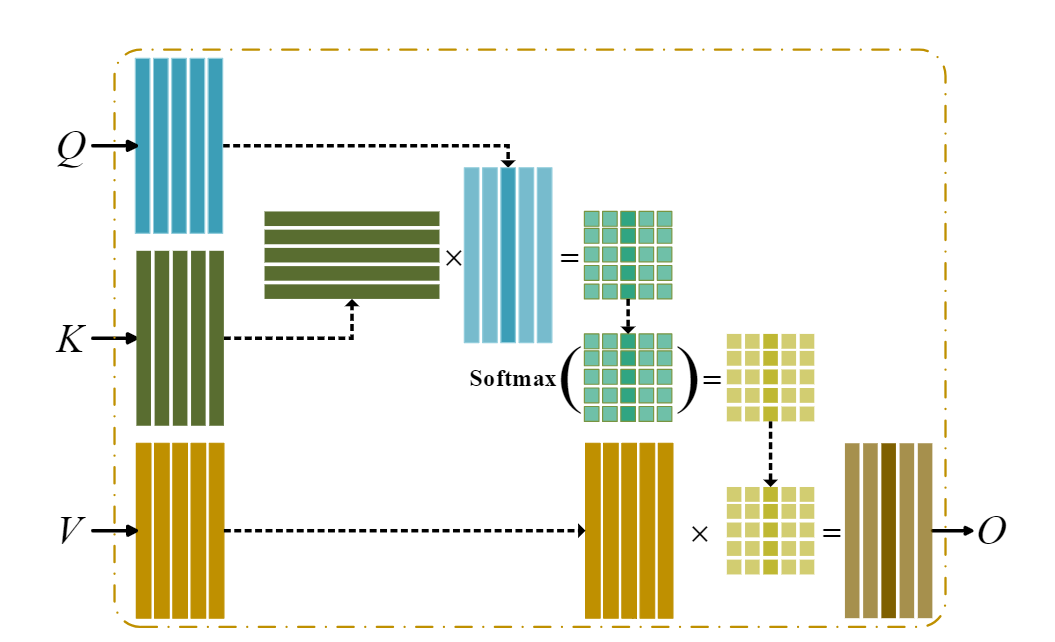
The multi-head attention implements the **attention pooling** operation, which is the heart of the transformer. It essentially relies on a weighted average of its value inputs, where the weights are determined by the key and query inputs. Here, we use scaled dot-product attention pooling:
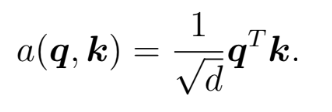

In the following, we provide as output not only the linear combination of each attention head, but also the attention pooling coefficients, in order to later show that we indeed focus the attention based on the relationship between the keys and the query.

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim

        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert embed_dim % self.num_heads == 0
        self.dim_per_head = embed_dim // self.num_heads

        # These are still of dimension embed_dim. They will be split into number of heads
        self.W_q = nn.Linear(embed_dim, embed_dim, bias=False) # 'k', 'v', 'q' stand for key, value, query
        self.W_k = nn.Linear(embed_dim, embed_dim, bias=False)
        self.W_v = nn.Linear(embed_dim, embed_dim, bias=False)

        # Output should be of dimension embed_dim
        self.W_h = nn.Linear(embed_dim, embed_dim)

    def scaled_dot_product_attention(self, Q, K, V):
        # Scaling by dim_per_head so that the softmax does not saturate
        Q = Q / np.sqrt(self.dim_per_head)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length) = (bs, n_heads, q_length, dim_per_head) X (bs, n_heads, dim_per_head, k_length)

        A = nn.Softmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)

        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head) = (bs, n_heads, q_length, k_length) X (bs, n_heads, v_length, dim_per_head)

        return H, A


    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X dim_per_head)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X seq_dim_per_head)
        """
        return x.view(batch_size, -1, self.num_heads, self.dim_per_head).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads X dim_per_head))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.dim_per_head) # 'contiguous' - a tensor whose elements are stored with no empty spaces in between


    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, _ = X_q.size()

        # After transforming, split into num_heads
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)

        # Calculate the attention weights for each of the heads
        H, A = self.scaled_dot_product_attention(Q, K, V) # (bs, n_heads, q_length, dim_per_head), (bs, n_heads, q_length, k_length)

        # Put all the heads back together by concat
        H_cat = self.group_heads(H, batch_size)    # (bs, q_length, embed_dim)

        # Final linear layer
        H = self.W_h(H_cat)          # (bs, q_length, embed_dim)

        return H, A  # we also output the attention tensor A for debugging

### Sanity check -  self attention works
To check our self attention works, we inspect that if the query matches with one of the key values, it should have all the attention focused there, with the value returned as the value at that index. So let's create a single model and define the following function:

In [7]:
temp_mha = MultiHeadAttention(embed_dim=512, num_heads=8)
# printing the outputs of the multi head attention
def print_out(Q, K, V):
    temp_out, temp_attn = temp_mha.scaled_dot_product_attention(Q, K, V)
    print('Attention weights are:', temp_attn.squeeze())
    print('Output is:', temp_out.squeeze())
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left subplot: Heatmap
    # Reshape the 1D array to a 2D array for the heatmap (e.g., a single row)
    sns.heatmap(temp_attn.squeeze().view(1,-1), ax=axes[0], cmap='Reds', cbar=True, annot=True, fmt=".1f")
    axes[0].set_title('Attention Weights')
    axes[0].set_xlabel('Index')
    axes[0].set_ylabel('') # No y-label for single row heatmap
    axes[0].set_yticks([]) # Hide y-axis ticks

    out = temp_out.squeeze()

    # Right subplot: Bar plot
    sns.barplot(x=list(range(len(out))), y=out, ax=axes[1], palette='Reds_r')
    axes[1].set_title('Output Vector')
    axes[1].set_xlabel('Index')
    axes[1].set_ylabel('Value')

    plt.tight_layout()
    plt.show()

Test 1: query matches a single key:

In [8]:
 # Q, K, V should be of shape (bs, n_heads, v_length, dim_per_head)

test_K = torch.tensor(
    [[10, 0, 0],
     [ 0,10, 0],
     [ 0, 0,10],
     [ 0, 0,10]]
).float()[None, None] # [None, None] unsqueezes the first two diemnsions

test_V = torch.tensor(
    [[   1,0,0],
     [  10,0,0],
     [ 100,5,0],
     [1000,6,0]]
).float()

test_Q = torch.tensor(
    [[0, 10, 0]]
).float()

Attention weights are: tensor([3.7266e-06, 9.9999e-01, 3.7266e-06, 3.7266e-06])
Output is: tensor([1.0004e+01, 4.0993e-05, 0.0000e+00])


/tmp/ipython-input-3708041702.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(out))), y=out, ax=axes[1], palette='Reds_r')


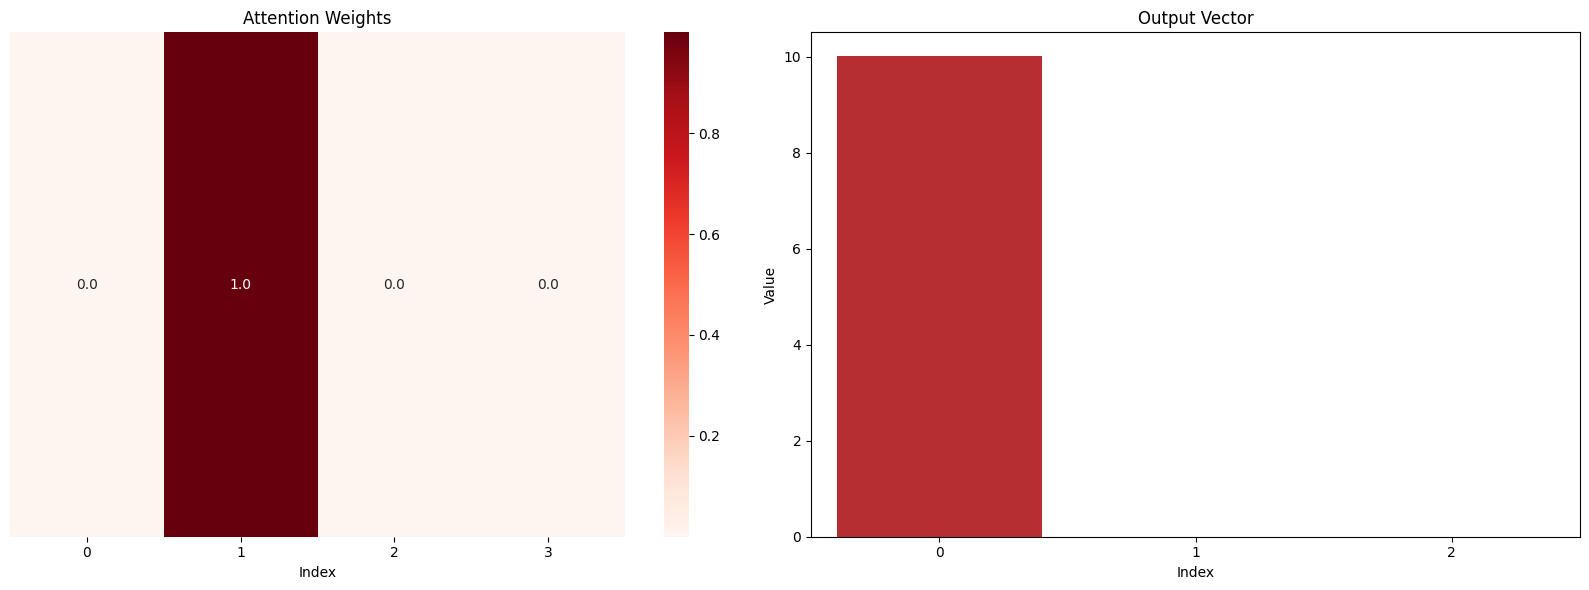

In [9]:
print_out(test_Q, test_K, test_V)

We can see that it focuses on the second key and returns the second value.


Test 2: query matches two key:

Attention weights are: tensor([1.8633e-06, 1.8633e-06, 5.0000e-01, 5.0000e-01])
Output is: tensor([549.9979,   5.5000,   0.0000])


/tmp/ipython-input-3708041702.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(range(len(out))), y=out, ax=axes[1], palette='Reds_r')


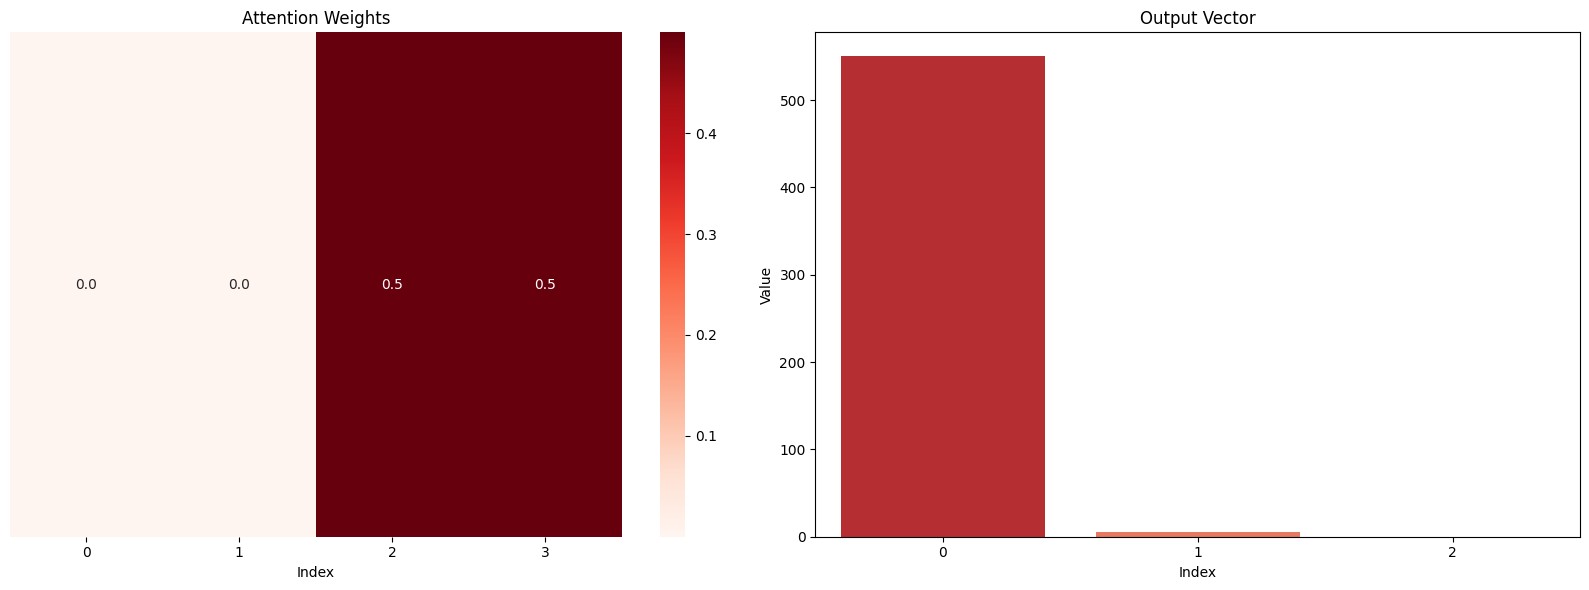

In [10]:
test_Q = torch.tensor([[0, 0, 10]]).float()
print_out(test_Q, test_K, test_V)

We see that it focuses equally on the third and fourth key and returns the average of their values.

## 1D convolution
This is basically an MLP with one hidden layer and ReLU activation applied to each and every element in the set.

In [11]:
class CNN(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.k1convL1 = nn.Linear(embed_dim, hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, embed_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

## The encoder layer
Now we have all components for our Transformer Encoder block as illustrated below. We can pack it all into an encoder layer:

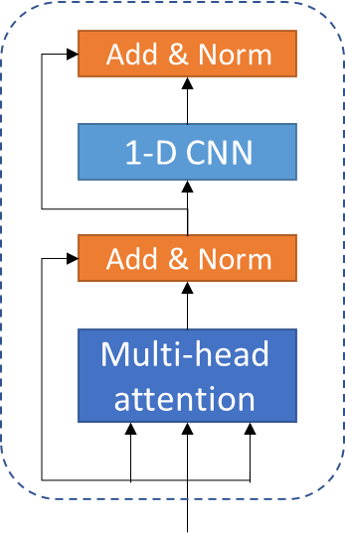

In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, conv_hidden_dim):
        super().__init__()

        self.mha = MultiHeadAttention(embed_dim, num_heads)
        self.cnn = CNN(embed_dim, conv_hidden_dim)

        self.layernorm1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)

    def forward(self, x):

        # Multi-head attention
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, embed_dim)

        # Layer norm after adding the residual connection
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, embed_dim)

        # Feed forward
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, embed_dim)

        #Second layer norm after adding residual connection
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, embed_dim)

        return out2

# Transformer Encoder

The encoder module of the transformer is comprised of the following architecture:

1.   Word embedding
2.   Positional encoding
3.   $N$ encoder layers

## Word embedding
For word embedding we will again use the `nn.Embedding` utility, this time with the vocabulary generated from the current dataset.

In [13]:
num_words = 50_000 # If you set max_size=50000, then your vocab size should be 50002 for your 50000 most frequently occurring unique terms plus <unk> (unknown word) + <pad>.
text.build_vocab(ds_train, max_size=num_words) # replaces the strings in the 'text' fields of ds_train with thier correspoding builded vocab indexes
label.build_vocab(ds_train) # replaces the strings in the 'label' fields of ds_train with thier correspoding builded vocab indexes

In [14]:
print(text.vocab.stoi["is"])
print(text.vocab.stoi["an"])

print(label.vocab.stoi["pos"])
print(label.vocab.stoi["neg"])

7
32
0
1


 ## Positional encoding

> Add blockquote


 For positional encoding, we will use shifted sinusoidals. Here the constant $p_{i,j}$ which  is added to the $j$th element (out of $d$) of the input vector at time instance $i$ is given by:
\begin{equation}
p_{i,j}=\begin{cases}
\sin\left(\frac{i}{10000^{2k/d}}\right) & j=2k\\
\cos\left(\frac{i}{10000^{2k/d}}\right) & j=2k+1
\end{cases};\quad k\in\mathbb{N}
\end{equation}

![Sinosoidal Encoding Illustration](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*VHlNV92K7VxFFeJOKu1-bA.png)
Source: Hiroaki Kobo's Medium post at https://medium.com/@hirok4/understanding-transformer-sinusoidal-position-embedding-7cbaaf3b9f6a

In [15]:
def create_sinusoidal_embeddings(nb_i, dim, p_offset):
    theta = np.array([
        [i / np.power(10000, 2*(j//2) / dim) for j in range(dim)]
        for i in range(nb_i)
    ])
    with torch.no_grad(): # 'with' statement replaces a try-catch block with a concise shorthand
      p_offset[:, 0::2] = torch.tensor(np.sin(theta[:, 0::2]))
      p_offset[:, 1::2] = torch.tensor(np.cos(theta[:, 1::2]))
      p_offset.detach_()
    p_offset.requires_grad = False

Combining word embedding and positional encoding into a single *Embedding* input class

In [16]:
class Embeddings(nn.Module):
    def __init__(self, embed_dim, vocab_size, max_position_embeddings):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_embeddings = nn.Embedding(max_position_embeddings, embed_dim)
        create_sinusoidal_embeddings(
            nb_i=max_position_embeddings,
            dim=embed_dim,
            p_offset=self.position_embeddings.weight
        )

        self.LayerNorm = nn.LayerNorm(embed_dim, eps=1e-12)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        # Get the position (time) ids for the input sequence.
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # (max_seq_length)
        position_ids = position_ids.unsqueeze(0) #.expand_as(input_ids)                      # (bs, max_seq_length)

        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)

        # Get position embeddings for each position id
        position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)

        # Add them both
        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)

        # Layer norm
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

## Encoder Module
We can now define the encoder module as a concatanation of the embedding model and a configurable number of encoder layers, where the output is merely the output of the final encoder layer.

In [17]:
class Encoder(nn.Module):
    def __init__(self, num_layers, embed_dim, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_layers = num_layers

        self.embedding = Embeddings(embed_dim, input_vocab_size,maximum_position_encoding)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(embed_dim, num_heads, ff_hidden_dim))

    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, embed_dim)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, embed_dim)

## Transformer Classifier
The transformer classifier is just an encoder with a fully-connected layer applied to its output, mapping it into a $2\times 1$ vector for classification.
<!-- Note that the sequence length here is limited to $10000$ words. -->

Since the dimensions of the encoder block output depend on the length of the input sequence, we need to combine the outputs for each sample (word). What we do here to that aim is take the per-entry max over all words.

In [18]:
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, embed_dim, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()

        self.encoder = Encoder(num_layers, embed_dim, num_heads, conv_hidden_dim, input_vocab_size,
                         maximum_position_encoding=max_len)
        self.dense = nn.Linear(embed_dim, num_answers)

    def forward(self, x):
        x = self.encoder(x)

        x, _ = torch.max(x, dim=1)
        x = self.dense(x)
        return x

Let's see how many parameters do we have

In [19]:
model = TransformerClassifier(num_layers=1, embed_dim=32, num_heads=2,
                         conv_hidden_dim=128, input_vocab_size=50002, num_answers=2).to(device)

from decimal import Decimal
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

print(f'Number of parameters is {Decimal(get_n_params(model)):.2E}')


Number of parameters is 1.62E+6


# Train and Test Functions

We train our models using the Adam optimizer with the (binary) cross entropy loss

In [20]:
def train(model,train_loader, valid_loader,num_epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_acc, valid_acc = [], []
    epochs = []
    for epoch in range(num_epochs):
        train_iterator, valid_iterator = iter(train_loader), iter(valid_loader)
        nb_batches_train = len(train_loader)
        train_correct = 0
        losses = 0.0

        model.train()
        for batch in train_iterator:
            x, y = batch.text, batch.label
            out = model(x)
            loss = f.cross_entropy(out, y)

            model.zero_grad()
            loss.backward()
            losses += loss.item()
            optimizer.step()
            train_correct += (out.argmax(1) == y).cpu().numpy().mean()

        # Save error on each epoch
        epochs.append(epoch)
        eval_acc = evaluate(model, valid_loader)
        print(f"Epoch {epoch} | Training: loss={(losses / nb_batches_train):.2} acc={(train_correct / nb_batches_train):.2} | Validation: acc={eval_acc:.2}")
        train_acc.append(train_correct / nb_batches_train)
        valid_acc.append(eval_acc)

    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

... and the test function which just loops over the test batches and computes the model accuracy.

In [21]:
def evaluate(model, data_loader):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0
    for batch in data_iterator:
        x, y = batch.text, batch.label
        out = model(x)
        acc += (out.argmax(1) == y).cpu().numpy().mean()
    eval_acc = acc / nb_batches
    return eval_acc

Let's apply

Epoch 0 | Training: loss=0.68 acc=0.57 | Validation: acc=0.64
Epoch 1 | Training: loss=0.61 acc=0.67 | Validation: acc=0.67
Epoch 2 | Training: loss=0.54 acc=0.74 | Validation: acc=0.74
Epoch 3 | Training: loss=0.46 acc=0.79 | Validation: acc=0.77
Epoch 4 | Training: loss=0.39 acc=0.83 | Validation: acc=0.8
Epoch 5 | Training: loss=0.33 acc=0.86 | Validation: acc=0.81
Epoch 6 | Training: loss=0.27 acc=0.89 | Validation: acc=0.82
Epoch 7 | Training: loss=0.22 acc=0.91 | Validation: acc=0.82
Epoch 8 | Training: loss=0.18 acc=0.94 | Validation: acc=0.82
Epoch 9 | Training: loss=0.15 acc=0.95 | Validation: acc=0.83


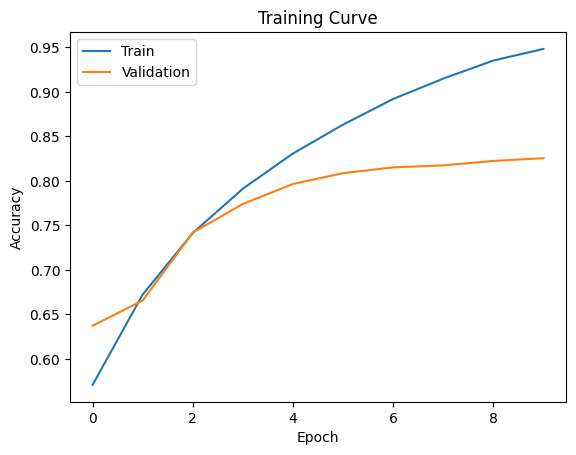

0.8083098641443931


In [22]:
train(model, train_loader, valid_loader)
print(evaluate(model, test_loader))